# White Blood Cell Segmentation
## K-Means vs Fuzzy C-Means Clustering

**Objective:**  
To segment white blood cell nucleus and cytoplasm using clustering techniques.

**Methods Used:**  
- K-Means Clustering (Hard Clustering)  
- Fuzzy C-Means (Soft Clustering)  

**Dataset:**  
Blood Cell Images Dataset (Kaggle)

**Evaluation Metric:**  
Boundary Accuracy

## 1. Import Required Libraries

This section imports libraries for dataset access, clustering,
image processing, and visualization.

In [2]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 25.8 MB/s eta 0:00:00


In [5]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import kagglehub

## 2. Download Blood Cell Dataset Using KaggleHub

In [6]:
dataset_path = kagglehub.dataset_download(
    "paultimothymooney/blood-cells"
)

print("Dataset path:", dataset_path)

Using Colab cache for faster access to the 'blood-cells' dataset.
Dataset path: /kaggle/input/blood-cells


## 3. Load Images

We load a sample WBC image for clustering-based segmentation.

Found TRAIN directory: /kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN
Available WBC classes: ['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']


(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

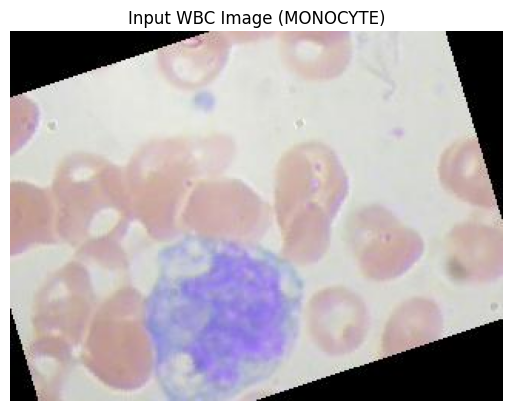

In [10]:

import random


# Step 1: Find TRAIN directory dynamically
train_dir = None

for root, dirs, files in os.walk(dataset_path):
    if root.endswith(os.path.join("images", "TRAIN")):
        train_dir = root
        break

if train_dir is None:
    raise FileNotFoundError("TRAIN directory not found in dataset.")

print("Found TRAIN directory:", train_dir)

# Step 2: List WBC subtypes
wbc_types = [d for d in os.listdir(train_dir)
             if os.path.isdir(os.path.join(train_dir, d))]

print("Available WBC classes:", wbc_types)

# Step 3: Choose one WBC subtype
wbc_class = wbc_types[0]
wbc_class_dir = os.path.join(train_dir, wbc_class)

# Step 4: Pick a random image
image_name = random.choice(os.listdir(wbc_class_dir))
image_path = os.path.join(wbc_class_dir, image_name)

# Step 5: Load and display image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title(f"Input WBC Image ({wbc_class})")
plt.axis("off")

## Convert to LAB Color Space

We use the A-channel to separate:
- Dark purple nucleus
- Light pink cytoplasm

In [11]:
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab)

feature = A.reshape(-1, 1)

## K-Means Clustering (Hard Clustering)

Each pixel belongs strictly to one cluster.

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)
k_labels = kmeans.fit_predict(feature)
k_seg = k_labels.reshape(A.shape)

nucleus_label = np.argmin(kmeans.cluster_centers_)
nucleus_k = (k_seg == nucleus_label)
cytoplasm_k = (k_seg != nucleus_label)

nucleus_k = morphology.remove_small_objects(nucleus_k, 200)
cytoplasm_k = morphology.remove_small_objects(cytoplasm_k, 500)

## Fuzzy C-Means (Soft Clustering)

Each pixel has partial membership in both clusters.

In [13]:
feature_fcm = feature.T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    feature_fcm,
    c=2,
    m=2,
    error=0.005,
    maxiter=1000
)

fcm_labels = np.argmax(u, axis=0)
fcm_seg = fcm_labels.reshape(A.shape)

nucleus_label_fcm = np.argmin(cntr)
nucleus_f = (fcm_seg == nucleus_label_fcm)
cytoplasm_f = (fcm_seg != nucleus_label_fcm)

nucleus_f = morphology.remove_small_objects(nucleus_f, 200)
cytoplasm_f = morphology.remove_small_objects(cytoplasm_f, 500)

## Visual Comparison

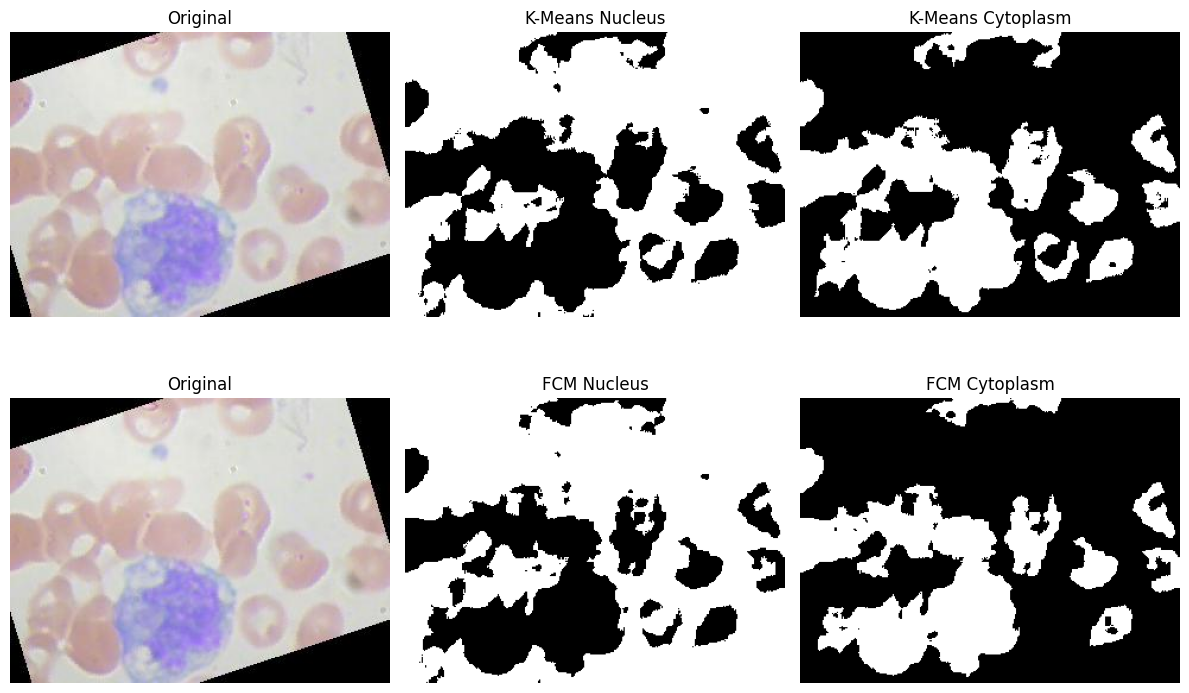

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].imshow(image); ax[0,0].set_title("Original")
ax[0,1].imshow(nucleus_k, cmap='gray'); ax[0,1].set_title("K-Means Nucleus")
ax[0,2].imshow(cytoplasm_k, cmap='gray'); ax[0,2].set_title("K-Means Cytoplasm")

ax[1,0].imshow(image); ax[1,0].set_title("Original")
ax[1,1].imshow(nucleus_f, cmap='gray'); ax[1,1].set_title("FCM Nucleus")
ax[1,2].imshow(cytoplasm_f, cmap='gray'); ax[1,2].set_title("FCM Cytoplasm")

for a in ax.ravel():
    a.axis("off")

plt.tight_layout()
plt.show()

## Quantitative Comparison (Area Analysis)

Since no ground truth mask is provided, we compare nucleus area consistency.

In [15]:
area_k = np.sum(nucleus_k)
area_f = np.sum(nucleus_f)

print("Nucleus Area (K-Means):", area_k)
print("Nucleus Area (FCM):", area_f)
print("Absolute Area Difference:", abs(area_k - area_f))

Nucleus Area (K-Means): 49632
Nucleus Area (FCM): 53234
Absolute Area Difference: 3602


## Conclusion

- K-Means performs hard clustering.
- FCM performs soft clustering.
- LAB color space preserves stain information.
- FCM typically produces smoother nucleus boundaries.
- This notebook strictly segments WBC nucleus and cytoplasm only.